In [1]:
from u import *
from ut import *
from model import *
from data import *

%load_ext autoreload
%autoreload 2

decoder = (Cache / 'vocab.npy').load()
encoder = get_encoder(decoder)
n_vocab = len(decoder)

In [2]:
import distiller
from main import get_net, get_opt, evaluate
c = Config(Wiki / 'shallow,layers_8,cache', device='cuda:0', logger=False, local_rank=0).load()
net = get_net(c)
data_tr = SampleIterator(c, c.train_batch, split='valid' if c.debug else 'train')
iter_tr = iter(data_tr)
data_val = SequentialIterator(c, c.eval_batch, split='valid')

In [4]:
distill_str = """
pruners:
  test_pruner:
      class: AutomatedGradualPruner
      initial_sparsity: 0.01
      final_sparsity: 1.00
      weights: []
policies:
  - pruner:
      instance_name: test_pruner
    starting_epoch: 0
    ending_epoch: 20
    frequency: 1
"""

In [5]:
def evaluate_step():
    density = distiller.density(layer_matrix)
    loss = evaluate(c, data_val, net)['loss']
    ppl = np.e ** loss if loss < 5 else np.nan
    return density, ppl

with torch.no_grad():
    info = OrderedDict()
    for layer_name, layer_matrix in tqdm(net.named_parameters()):
        numel = layer_matrix.numel()
        if numel < 5000:
            continue
        print(layer_name)
        c.init_model(net, step='max', train=False)
        d_c = yaml.load(distill_str)
        d_c['pruners']['test_pruner']['weights'].append(layer_name)
        compression_scheduler = distiller.config.dict_config(net, None, d_c)
        info_layer = []
        
        print('Initial density %.5g ppl %.5g' % evaluate_step())
        for epoch in range(20):
            compression_scheduler.on_epoch_begin(epoch)
            compression_scheduler.on_minibatch_begin(epoch, minibatch_id=1, minibatches_per_epoch=1)
            x = to_torch(next(iter_tr), c.device).t()
            inputs, labels = x[:-1], x[1:]
            preds = net(inputs, labels)
            loss = preds['loss']
            loss = compression_scheduler.before_backward_pass(epoch, minibatch_id=1,
                                                                   minibatches_per_epoch=1,
                                                                   loss=loss, return_loss_components=False)
            compression_scheduler.on_minibatch_end(epoch, minibatch_id=1, minibatches_per_epoch=1)
            compression_scheduler.on_epoch_end(epoch)
            density, ppl = evaluate_step()
            print('Epoch %s density %.5g ppl %.5g' % (epoch + 1, density, ppl))
            info_layer.append([epoch, density, ppl])
            if np.isnan(ppl) or ppl > 40:
                break
        print()
        info[layer_name] = (numel, info_layer)


0it [00:00, ?it/s]

embed.layers.0.weight
Initial density 1 ppl 32.021
Epoch 1 density 0.99 ppl 32.02
Epoch 2 density 0.84177 ppl 32.617
Epoch 3 density 0.70912 ppl 35.826



1it [00:08,  8.92s/it]

Epoch 4 density 0.5912 ppl 44.305

embed.layers.1.weight
Initial density 1 ppl 32.021
Epoch 1 density 0.99 ppl 32.02
Epoch 2 density 0.84177 ppl 32.092
Epoch 3 density 0.70912 ppl 32.446
Epoch 4 density 0.5912 ppl 33.278
Epoch 5 density 0.48713 ppl 34.742
Epoch 6 density 0.39606 ppl 36.888
Epoch 7 density 0.31711 ppl 39.817



2it [00:24, 11.04s/it]

Epoch 8 density 0.24941 ppl 43.884

embed.layers.2.weight
Initial density 1 ppl 32.02
Epoch 1 density 0.99 ppl 32.02
Epoch 2 density 0.84177 ppl 32.162
Epoch 3 density 0.70912 ppl 32.807
Epoch 4 density 0.5912 ppl 34.067
Epoch 5 density 0.48713 ppl 35.491
Epoch 6 density 0.39606 ppl 37.407
Epoch 7 density 0.31711 ppl 39.625



3it [00:40, 12.54s/it]

Epoch 8 density 0.24941 ppl 41.444

embed.projections.0.weight
Initial density 1 ppl 32.02
Epoch 1 density 0.99005 ppl 32.021
Epoch 2 density 0.8418 ppl 32.041
Epoch 3 density 0.70917 ppl 32.16
Epoch 4 density 0.59125 ppl 32.364
Epoch 5 density 0.48718 ppl 32.791
Epoch 6 density 0.39612 ppl 33.376
Epoch 7 density 0.31714 ppl 34.222
Epoch 8 density 0.24945 ppl 35.355
Epoch 9 density 0.19214 ppl 36.603
Epoch 10 density 0.14435 ppl 38.512



4it [01:02, 15.16s/it]

Epoch 11 density 0.10522 ppl 40.594

layers.0.qkv.weight
Initial density 1 ppl 32.02
Epoch 1 density 0.99 ppl 32.022
Epoch 2 density 0.84177 ppl 32.038
Epoch 3 density 0.70913 ppl 32.138
Epoch 4 density 0.5912 ppl 32.439
Epoch 5 density 0.48714 ppl 32.951
Epoch 6 density 0.39606 ppl 33.962
Epoch 7 density 0.31711 ppl 35.3
Epoch 8 density 0.24942 ppl 37.078
Epoch 9 density 0.19211 ppl 39.159



9it [01:21, 11.79s/it]

Epoch 10 density 0.14434 ppl 41.297

layers.0.out.weight
Initial density 1 ppl 32.021
Epoch 1 density 0.99001 ppl 32.02
Epoch 2 density 0.84178 ppl 32.022
Epoch 3 density 0.70913 ppl 32.069
Epoch 4 density 0.59121 ppl 32.173
Epoch 5 density 0.48714 ppl 32.345
Epoch 6 density 0.39608 ppl 32.656
Epoch 7 density 0.31712 ppl 33.042
Epoch 8 density 0.24943 ppl 33.678
Epoch 9 density 0.19212 ppl 34.576
Epoch 10 density 0.14435 ppl 35.66
Epoch 11 density 0.10522 ppl 37.071
Epoch 12 density 0.073914 ppl 38.485
Epoch 13 density 0.04952 ppl 39.879



11it [01:48, 12.26s/it]

Epoch 14 density 0.031189 ppl 41.448

layers.0.fc.0.weight
Initial density 1 ppl 32.021
Epoch 1 density 0.99 ppl 32.021
Epoch 2 density 0.84177 ppl 32.069
Epoch 3 density 0.70913 ppl 32.315
Epoch 4 density 0.5912 ppl 32.971
Epoch 5 density 0.48714 ppl 34.214
Epoch 6 density 0.39606 ppl 36.534



14it [02:02, 10.01s/it]

Epoch 7 density 0.31711 ppl 40.422

layers.0.fc.3.weight
Initial density 1 ppl 32.021
Epoch 1 density 0.99 ppl 32.02
Epoch 2 density 0.84177 ppl 32.129
Epoch 3 density 0.70913 ppl 32.453
Epoch 4 density 0.5912 ppl 33.31
Epoch 5 density 0.48714 ppl 34.805
Epoch 6 density 0.39606 ppl 37.187



16it [02:17,  9.15s/it]

Epoch 7 density 0.31711 ppl 40.075

layers.1.qkv.weight
Initial density 1 ppl 32.021
Epoch 1 density 0.99 ppl 32.02
Epoch 2 density 0.84177 ppl 32.034
Epoch 3 density 0.70913 ppl 32.117
Epoch 4 density 0.5912 ppl 32.34
Epoch 5 density 0.48714 ppl 32.855
Epoch 6 density 0.39606 ppl 33.802
Epoch 7 density 0.31711 ppl 35.438
Epoch 8 density 0.24942 ppl 37.546
Epoch 9 density 0.19211 ppl 39.984



21it [02:36,  7.58s/it]

Epoch 10 density 0.14434 ppl 42.294

layers.1.out.weight
Initial density 1 ppl 32.02
Epoch 1 density 0.99001 ppl 32.021
Epoch 2 density 0.84178 ppl 32.032
Epoch 3 density 0.70913 ppl 32.076
Epoch 4 density 0.59121 ppl 32.149
Epoch 5 density 0.48714 ppl 32.281
Epoch 6 density 0.39608 ppl 32.465
Epoch 7 density 0.31712 ppl 32.776
Epoch 8 density 0.24943 ppl 33.213
Epoch 9 density 0.19212 ppl 33.867
Epoch 10 density 0.14435 ppl 34.659
Epoch 11 density 0.10522 ppl 35.633
Epoch 12 density 0.073914 ppl 37.03
Epoch 13 density 0.04952 ppl 38.655



23it [03:03,  9.32s/it]

Epoch 14 density 0.031189 ppl 40.338

layers.1.fc.0.weight
Initial density 1 ppl 32.02
Epoch 1 density 0.99 ppl 32.02
Epoch 2 density 0.84177 ppl 32.048
Epoch 3 density 0.70913 ppl 32.193
Epoch 4 density 0.5912 ppl 32.558
Epoch 5 density 0.48714 ppl 33.203
Epoch 6 density 0.39606 ppl 34.051
Epoch 7 density 0.31711 ppl 35.172
Epoch 8 density 0.24942 ppl 36.342
Epoch 9 density 0.19211 ppl 37.889
Epoch 10 density 0.14434 ppl 39.441



26it [03:25,  8.68s/it]

Epoch 11 density 0.10522 ppl 41.365

layers.1.fc.3.weight
Initial density 1 ppl 32.02
Epoch 1 density 0.99 ppl 32.021
Epoch 2 density 0.84177 ppl 32.036
Epoch 3 density 0.70913 ppl 32.127
Epoch 4 density 0.5912 ppl 32.35
Epoch 5 density 0.48714 ppl 32.712
Epoch 6 density 0.39606 ppl 33.192
Epoch 7 density 0.31711 ppl 33.858
Epoch 8 density 0.24942 ppl 34.685
Epoch 9 density 0.19211 ppl 35.647
Epoch 10 density 0.14434 ppl 36.711
Epoch 11 density 0.10522 ppl 37.908
Epoch 12 density 0.073903 ppl 39.311



28it [03:50,  9.82s/it]

Epoch 13 density 0.04951 ppl 40.829

layers.2.qkv.weight
Initial density 1 ppl 32.02
Epoch 1 density 0.99 ppl 32.023
Epoch 2 density 0.84177 ppl 32.033
Epoch 3 density 0.70913 ppl 32.103
Epoch 4 density 0.5912 ppl 32.252
Epoch 5 density 0.48714 ppl 32.629
Epoch 6 density 0.39606 ppl 33.246
Epoch 7 density 0.31711 ppl 34.272
Epoch 8 density 0.24942 ppl 35.575
Epoch 9 density 0.19211 ppl 36.844
Epoch 10 density 0.14434 ppl 37.96
Epoch 11 density 0.10522 ppl 38.741
Epoch 12 density 0.0739 ppl 39.104
Epoch 13 density 0.049513 ppl 39.264
Epoch 14 density 0.031182 ppl 39.328
Epoch 15 density 0.018046 ppl 39.371
Epoch 16 density 0.0092434 ppl 39.371
Epoch 17 density 0.0038995 ppl 39.355
Epoch 18 density 0.0011597 ppl 39.354
Epoch 19 density 0.0001492 ppl 39.355



33it [04:27,  9.13s/it]

Epoch 20 density 0 ppl 39.352

layers.2.out.weight
Initial density 1 ppl 32.021
Epoch 1 density 0.99001 ppl 32.021
Epoch 2 density 0.84178 ppl 32.023
Epoch 3 density 0.70913 ppl 32.048
Epoch 4 density 0.59121 ppl 32.09
Epoch 5 density 0.48714 ppl 32.181
Epoch 6 density 0.39608 ppl 32.311
Epoch 7 density 0.31712 ppl 32.501
Epoch 8 density 0.24943 ppl 32.777
Epoch 9 density 0.19212 ppl 33.126
Epoch 10 density 0.14435 ppl 33.548
Epoch 11 density 0.10522 ppl 34.029
Epoch 12 density 0.073914 ppl 34.615
Epoch 13 density 0.04952 ppl 35.309
Epoch 14 density 0.031189 ppl 35.987
Epoch 15 density 0.018046 ppl 36.781
Epoch 16 density 0.009257 ppl 37.456
Epoch 17 density 0.0039062 ppl 38.014
Epoch 18 density 0.0011597 ppl 38.418
Epoch 19 density 0.00016276 ppl 38.543



35it [05:05, 12.00s/it]

Epoch 20 density 0 ppl 38.543

layers.2.fc.0.weight
Initial density 1 ppl 32.021
Epoch 1 density 0.99 ppl 32.021
Epoch 2 density 0.84177 ppl 32.049
Epoch 3 density 0.70913 ppl 32.201
Epoch 4 density 0.5912 ppl 32.601
Epoch 5 density 0.48714 ppl 33.357
Epoch 6 density 0.39606 ppl 34.387
Epoch 7 density 0.31711 ppl 35.832
Epoch 8 density 0.24942 ppl 37.248
Epoch 9 density 0.19211 ppl 38.983



38it [05:24, 10.37s/it]

Epoch 10 density 0.14434 ppl 40.573

layers.2.fc.3.weight
Initial density 1 ppl 32.021
Epoch 1 density 0.99 ppl 32.02
Epoch 2 density 0.84177 ppl 32.035
Epoch 3 density 0.70913 ppl 32.139
Epoch 4 density 0.5912 ppl 32.363
Epoch 5 density 0.48714 ppl 32.743
Epoch 6 density 0.39606 ppl 33.174
Epoch 7 density 0.31711 ppl 33.833
Epoch 8 density 0.24942 ppl 34.661
Epoch 9 density 0.19211 ppl 35.614
Epoch 10 density 0.14434 ppl 36.962
Epoch 11 density 0.10522 ppl 38.373
Epoch 12 density 0.073903 ppl 39.737



40it [05:49, 11.00s/it]

Epoch 13 density 0.04951 ppl 41.363

layers.3.qkv.weight
Initial density 1 ppl 32.021
Epoch 1 density 0.99 ppl 32.02
Epoch 2 density 0.84177 ppl 32.042
Epoch 3 density 0.70913 ppl 32.13
Epoch 4 density 0.5912 ppl 32.398
Epoch 5 density 0.48714 ppl 32.894
Epoch 6 density 0.39606 ppl 33.788
Epoch 7 density 0.31711 ppl 35.034
Epoch 8 density 0.24942 ppl 36.702
Epoch 9 density 0.19211 ppl 38.559



45it [06:09,  8.88s/it]

Epoch 10 density 0.14434 ppl 40.187

layers.3.out.weight
Initial density 1 ppl 32.021
Epoch 1 density 0.99001 ppl 32.02
Epoch 2 density 0.84178 ppl 32.029
Epoch 3 density 0.70913 ppl 32.063
Epoch 4 density 0.59121 ppl 32.153
Epoch 5 density 0.48714 ppl 32.314
Epoch 6 density 0.39608 ppl 32.539
Epoch 7 density 0.31712 ppl 32.869
Epoch 8 density 0.24943 ppl 33.343
Epoch 9 density 0.19212 ppl 33.934
Epoch 10 density 0.14435 ppl 34.674
Epoch 11 density 0.10522 ppl 35.609
Epoch 12 density 0.073914 ppl 36.709
Epoch 13 density 0.04952 ppl 37.831
Epoch 14 density 0.031189 ppl 39.078



47it [06:37, 10.51s/it]

Epoch 15 density 0.018046 ppl 40.275

layers.3.fc.0.weight
Initial density 1 ppl 32.021
Epoch 1 density 0.99 ppl 32.02
Epoch 2 density 0.84177 ppl 32.048
Epoch 3 density 0.70913 ppl 32.179
Epoch 4 density 0.5912 ppl 32.476
Epoch 5 density 0.48714 ppl 33.009
Epoch 6 density 0.39606 ppl 33.757
Epoch 7 density 0.31711 ppl 34.672
Epoch 8 density 0.24942 ppl 35.712
Epoch 9 density 0.19211 ppl 36.944
Epoch 10 density 0.14434 ppl 37.935
Epoch 11 density 0.10522 ppl 38.587
Epoch 12 density 0.073903 ppl 39.43



50it [07:02,  9.85s/it]

Epoch 13 density 0.04951 ppl 40.47

layers.3.fc.3.weight
Initial density 1 ppl 32.021
Epoch 1 density 0.99 ppl 32.02
Epoch 2 density 0.84177 ppl 32.039
Epoch 3 density 0.70913 ppl 32.122
Epoch 4 density 0.5912 ppl 32.287
Epoch 5 density 0.48714 ppl 32.564
Epoch 6 density 0.39606 ppl 32.933
Epoch 7 density 0.31711 ppl 33.461
Epoch 8 density 0.24942 ppl 34.081
Epoch 9 density 0.19211 ppl 34.752
Epoch 10 density 0.14434 ppl 35.509
Epoch 11 density 0.10522 ppl 36.422
Epoch 12 density 0.073903 ppl 37.525
Epoch 13 density 0.04951 ppl 38.612
Epoch 14 density 0.031179 ppl 39.591



52it [07:31, 11.18s/it]

Epoch 15 density 0.018046 ppl 40.623

layers.4.qkv.weight
Initial density 1 ppl 32.021
Epoch 1 density 0.99 ppl 32.019
Epoch 2 density 0.84177 ppl 32.048
Epoch 3 density 0.70913 ppl 32.152
Epoch 4 density 0.5912 ppl 32.421
Epoch 5 density 0.48714 ppl 32.943
Epoch 6 density 0.39606 ppl 33.845
Epoch 7 density 0.31711 ppl 35.251
Epoch 8 density 0.24942 ppl 37.293



57it [07:49,  8.91s/it]

Epoch 9 density 0.19211 ppl 40.13

layers.4.out.weight
Initial density 1 ppl 32.02
Epoch 1 density 0.99001 ppl 32.021
Epoch 2 density 0.84178 ppl 32.03
Epoch 3 density 0.70913 ppl 32.068
Epoch 4 density 0.59121 ppl 32.167
Epoch 5 density 0.48714 ppl 32.334
Epoch 6 density 0.39608 ppl 32.619
Epoch 7 density 0.31712 ppl 33.012
Epoch 8 density 0.24943 ppl 33.552
Epoch 9 density 0.19212 ppl 34.184
Epoch 10 density 0.14435 ppl 35.139
Epoch 11 density 0.10522 ppl 36.326
Epoch 12 density 0.073914 ppl 37.749
Epoch 13 density 0.04952 ppl 39.299



59it [08:16, 10.27s/it]

Epoch 14 density 0.031189 ppl 40.973

layers.4.fc.0.weight
Initial density 1 ppl 32.02
Epoch 1 density 0.99 ppl 32.02
Epoch 2 density 0.84177 ppl 32.035
Epoch 3 density 0.70913 ppl 32.16
Epoch 4 density 0.5912 ppl 32.456
Epoch 5 density 0.48714 ppl 32.899
Epoch 6 density 0.39606 ppl 33.594
Epoch 7 density 0.31711 ppl 34.197
Epoch 8 density 0.24942 ppl 35.02
Epoch 9 density 0.19211 ppl 35.915
Epoch 10 density 0.14434 ppl 37.001
Epoch 11 density 0.10522 ppl 38.241
Epoch 12 density 0.073903 ppl 39.687



62it [08:41,  9.71s/it]

Epoch 13 density 0.04951 ppl 41.172

layers.4.fc.3.weight
Initial density 1 ppl 32.021
Epoch 1 density 0.99 ppl 32.02
Epoch 2 density 0.84177 ppl 32.028
Epoch 3 density 0.70913 ppl 32.124
Epoch 4 density 0.5912 ppl 32.333
Epoch 5 density 0.48714 ppl 32.664
Epoch 6 density 0.39606 ppl 33.152
Epoch 7 density 0.31711 ppl 33.747
Epoch 8 density 0.24942 ppl 34.555
Epoch 9 density 0.19211 ppl 35.687
Epoch 10 density 0.14434 ppl 37.13
Epoch 11 density 0.10522 ppl 38.428



64it [09:04, 10.28s/it]

Epoch 12 density 0.073903 ppl 40.029

layers.5.qkv.weight
Initial density 1 ppl 32.021
Epoch 1 density 0.99 ppl 32.021
Epoch 2 density 0.84177 ppl 32.035
Epoch 3 density 0.70913 ppl 32.152
Epoch 4 density 0.5912 ppl 32.372
Epoch 5 density 0.48714 ppl 32.739
Epoch 6 density 0.39606 ppl 33.308
Epoch 7 density 0.31711 ppl 34.257
Epoch 8 density 0.24942 ppl 35.603
Epoch 9 density 0.19211 ppl 37.009
Epoch 10 density 0.14434 ppl 38.368
Epoch 11 density 0.10522 ppl 39.421



69it [09:28,  8.60s/it]

Epoch 12 density 0.0739 ppl 40.269

layers.5.out.weight
Initial density 1 ppl 32.021
Epoch 1 density 0.99001 ppl 32.02
Epoch 2 density 0.84178 ppl 32.026
Epoch 3 density 0.70913 ppl 32.055
Epoch 4 density 0.59121 ppl 32.151
Epoch 5 density 0.48714 ppl 32.28
Epoch 6 density 0.39608 ppl 32.506
Epoch 7 density 0.31712 ppl 32.848
Epoch 8 density 0.24943 ppl 33.236
Epoch 9 density 0.19212 ppl 33.754
Epoch 10 density 0.14435 ppl 34.409
Epoch 11 density 0.10522 ppl 35.184
Epoch 12 density 0.073914 ppl 36.024
Epoch 13 density 0.04952 ppl 37.047
Epoch 14 density 0.031189 ppl 38.059
Epoch 15 density 0.018046 ppl 39.083
Epoch 16 density 0.009257 ppl 39.933



71it [10:00, 10.83s/it]

Epoch 17 density 0.0039062 ppl 40.722

layers.5.fc.0.weight
Initial density 1 ppl 32.021
Epoch 1 density 0.99 ppl 32.02
Epoch 2 density 0.84177 ppl 32.039
Epoch 3 density 0.70913 ppl 32.176
Epoch 4 density 0.5912 ppl 32.521
Epoch 5 density 0.48714 ppl 33.06
Epoch 6 density 0.39606 ppl 33.79
Epoch 7 density 0.31711 ppl 34.712
Epoch 8 density 0.24942 ppl 35.632
Epoch 9 density 0.19211 ppl 36.672
Epoch 10 density 0.14434 ppl 37.846
Epoch 11 density 0.10522 ppl 39.323



74it [10:23,  9.89s/it]

Epoch 12 density 0.073903 ppl 40.854

layers.5.fc.3.weight
Initial density 1 ppl 32.021
Epoch 1 density 0.99 ppl 32.021
Epoch 2 density 0.84177 ppl 32.051
Epoch 3 density 0.70913 ppl 32.225
Epoch 4 density 0.5912 ppl 32.649
Epoch 5 density 0.48714 ppl 33.455
Epoch 6 density 0.39606 ppl 34.801
Epoch 7 density 0.31711 ppl 36.481
Epoch 8 density 0.24942 ppl 38.583



76it [10:41,  9.66s/it]

Epoch 9 density 0.19211 ppl 41.754

layers.6.qkv.weight
Initial density 1 ppl 32.021
Epoch 1 density 0.99 ppl 32.02
Epoch 2 density 0.84177 ppl 32.047
Epoch 3 density 0.70913 ppl 32.18
Epoch 4 density 0.5912 ppl 32.477
Epoch 5 density 0.48714 ppl 33.003
Epoch 6 density 0.39606 ppl 33.747
Epoch 7 density 0.31711 ppl 34.763
Epoch 8 density 0.24942 ppl 36.202
Epoch 9 density 0.19211 ppl 37.603
Epoch 10 density 0.14434 ppl 39.128



81it [11:03,  8.04s/it]

Epoch 11 density 0.10522 ppl 40.494

layers.6.out.weight
Initial density 1 ppl 32.02
Epoch 1 density 0.99001 ppl 32.021
Epoch 2 density 0.84178 ppl 32.024
Epoch 3 density 0.70913 ppl 32.075
Epoch 4 density 0.59121 ppl 32.198
Epoch 5 density 0.48714 ppl 32.376
Epoch 6 density 0.39608 ppl 32.667
Epoch 7 density 0.31712 ppl 33.086
Epoch 8 density 0.24943 ppl 33.592
Epoch 9 density 0.19212 ppl 34.24
Epoch 10 density 0.14435 ppl 34.984
Epoch 11 density 0.10522 ppl 35.937
Epoch 12 density 0.073914 ppl 36.964
Epoch 13 density 0.04952 ppl 38.151
Epoch 14 density 0.031189 ppl 39.243



83it [11:31,  9.92s/it]

Epoch 15 density 0.018046 ppl 40.272

layers.6.fc.0.weight
Initial density 1 ppl 32.02
Epoch 1 density 0.99 ppl 32.021
Epoch 2 density 0.84177 ppl 32.074
Epoch 3 density 0.70913 ppl 32.346
Epoch 4 density 0.5912 ppl 32.979
Epoch 5 density 0.48714 ppl 34.353
Epoch 6 density 0.39606 ppl 35.78
Epoch 7 density 0.31711 ppl 37.347
Epoch 8 density 0.24942 ppl 38.836



86it [11:49,  8.73s/it]

Epoch 9 density 0.19211 ppl 40.742

layers.6.fc.3.weight
Initial density 1 ppl 32.021
Epoch 1 density 0.99 ppl 32.02
Epoch 2 density 0.84177 ppl 32.084
Epoch 3 density 0.70913 ppl 32.421
Epoch 4 density 0.5912 ppl 33.3
Epoch 5 density 0.48714 ppl 34.782
Epoch 6 density 0.39606 ppl 37.388



88it [12:03,  8.26s/it]

Epoch 7 density 0.31711 ppl 41.045

layers.7.qkv.weight
Initial density 1 ppl 32.021
Epoch 1 density 0.99 ppl 32.021
Epoch 2 density 0.84177 ppl 32.123
Epoch 3 density 0.70913 ppl 32.642
Epoch 4 density 0.5912 ppl 33.768
Epoch 5 density 0.48714 ppl 35.62
Epoch 6 density 0.39606 ppl 38.408



93it [12:18,  6.64s/it]

Epoch 7 density 0.31711 ppl 41.83

layers.7.out.weight
Initial density 1 ppl 32.02
Epoch 1 density 0.99001 ppl 32.02
Epoch 2 density 0.84178 ppl 32.054
Epoch 3 density 0.70913 ppl 32.265
Epoch 4 density 0.59121 ppl 32.742
Epoch 5 density 0.48714 ppl 33.516
Epoch 6 density 0.39608 ppl 34.629
Epoch 7 density 0.31712 ppl 36.215
Epoch 8 density 0.24943 ppl 38.291



95it [12:36,  7.34s/it]

Epoch 9 density 0.19212 ppl 40.864

layers.7.fc.0.weight
Initial density 1 ppl 32.02
Epoch 1 density 0.99 ppl 32.02
Epoch 2 density 0.84177 ppl 32.072
Epoch 3 density 0.70913 ppl 32.421
Epoch 4 density 0.5912 ppl 33.609
Epoch 5 density 0.48714 ppl 36.468



98it [12:48,  6.39s/it]

Epoch 6 density 0.39606 ppl 44.364

layers.7.fc.3.weight
Initial density 1 ppl 32.02
Epoch 1 density 0.99 ppl 32.021
Epoch 2 density 0.84177 ppl 32.045
Epoch 3 density 0.70913 ppl 32.207
Epoch 4 density 0.5912 ppl 32.639
Epoch 5 density 0.48714 ppl 33.562
Epoch 6 density 0.39606 ppl 35.271
Epoch 7 density 0.31711 ppl 37.772



100it [13:04,  6.90s/it]

Epoch 8 density 0.24942 ppl 41.172

loss.layers.1.bias
Initial density 1 ppl 32.021
Epoch 1 density 0.99 ppl 32.02
Epoch 2 density 0.84177 ppl 32.022
Epoch 3 density 0.70916 ppl 32.021
Epoch 4 density 0.59121 ppl 32.03
Epoch 5 density 0.48716 ppl 32.036
Epoch 6 density 0.39609 ppl 32.062
Epoch 7 density 0.31712 ppl 32.077
Epoch 8 density 0.24944 ppl 32.095
Epoch 9 density 0.19214 ppl 32.118
Epoch 10 density 0.14437 ppl 32.147
Epoch 11 density 0.10526 ppl 32.171
Epoch 12 density 0.073907 ppl 32.203
Epoch 13 density 0.049535 ppl 32.223
Epoch 14 density 0.031209 ppl 32.247
Epoch 15 density 0.018047 ppl 32.277
Epoch 16 density 0.0092558 ppl 32.291
Epoch 17 density 0.003907 ppl 32.297
Epoch 18 density 0.0011628 ppl 32.297
Epoch 19 density 0.00018605 ppl 32.297



107it [13:42,  6.44s/it]

Epoch 20 density 0 ppl 32.296

loss.layers.2.bias
Initial density 1 ppl 32.02
Epoch 1 density 0.99 ppl 32.022
Epoch 2 density 0.84177 ppl 32.06
Epoch 3 density 0.70912 ppl 32.163
Epoch 4 density 0.5912 ppl 32.261
Epoch 5 density 0.48714 ppl 32.33
Epoch 6 density 0.39606 ppl 32.386
Epoch 7 density 0.31711 ppl 32.418
Epoch 8 density 0.24942 ppl 32.45
Epoch 9 density 0.19211 ppl 32.467
Epoch 10 density 0.14434 ppl 32.485
Epoch 11 density 0.10522 ppl 32.493
Epoch 12 density 0.073904 ppl 32.508
Epoch 13 density 0.049511 ppl 32.513
Epoch 14 density 0.031178 ppl 32.52
Epoch 15 density 0.018044 ppl 32.526
Epoch 16 density 0.0092405 ppl 32.528
Epoch 17 density 0.0038973 ppl 32.528
Epoch 18 density 0.0011576 ppl 32.532
Epoch 19 density 0.00014831 ppl 32.532



108it [14:19, 15.77s/it]

Epoch 20 density 0 ppl 32.534

loss.projections.0.weight
Initial density 1 ppl 32.02
Epoch 1 density 0.99005 ppl 32.021
Epoch 2 density 0.8418 ppl 32.203
Epoch 3 density 0.70917 ppl 32.981
Epoch 4 density 0.59125 ppl 34.624
Epoch 5 density 0.48718 ppl 34.844
Epoch 6 density 0.39612 ppl 35.782
Epoch 7 density 0.31714 ppl 36.747
Epoch 8 density 0.24945 ppl 37.922
Epoch 9 density 0.19214 ppl 39.22



109it [14:39, 16.94s/it]
110it [14:39,  8.00s/it]

Epoch 10 density 0.14435 ppl 40.627



In [3]:
from copy import deepcopy
c_sen = deepcopy(c)
c_sen.res = (Wiki / 'sensitivities,cache').mk()
# (c_sen.res / 'sensitivies.yaml').save(info)

In [8]:
info = (c_sen.res / 'sensitivities.npy').load().item()

In [5]:
%matplotlib inline

In [6]:
v = get_visdom(server='localhost')

Setting up a new session...


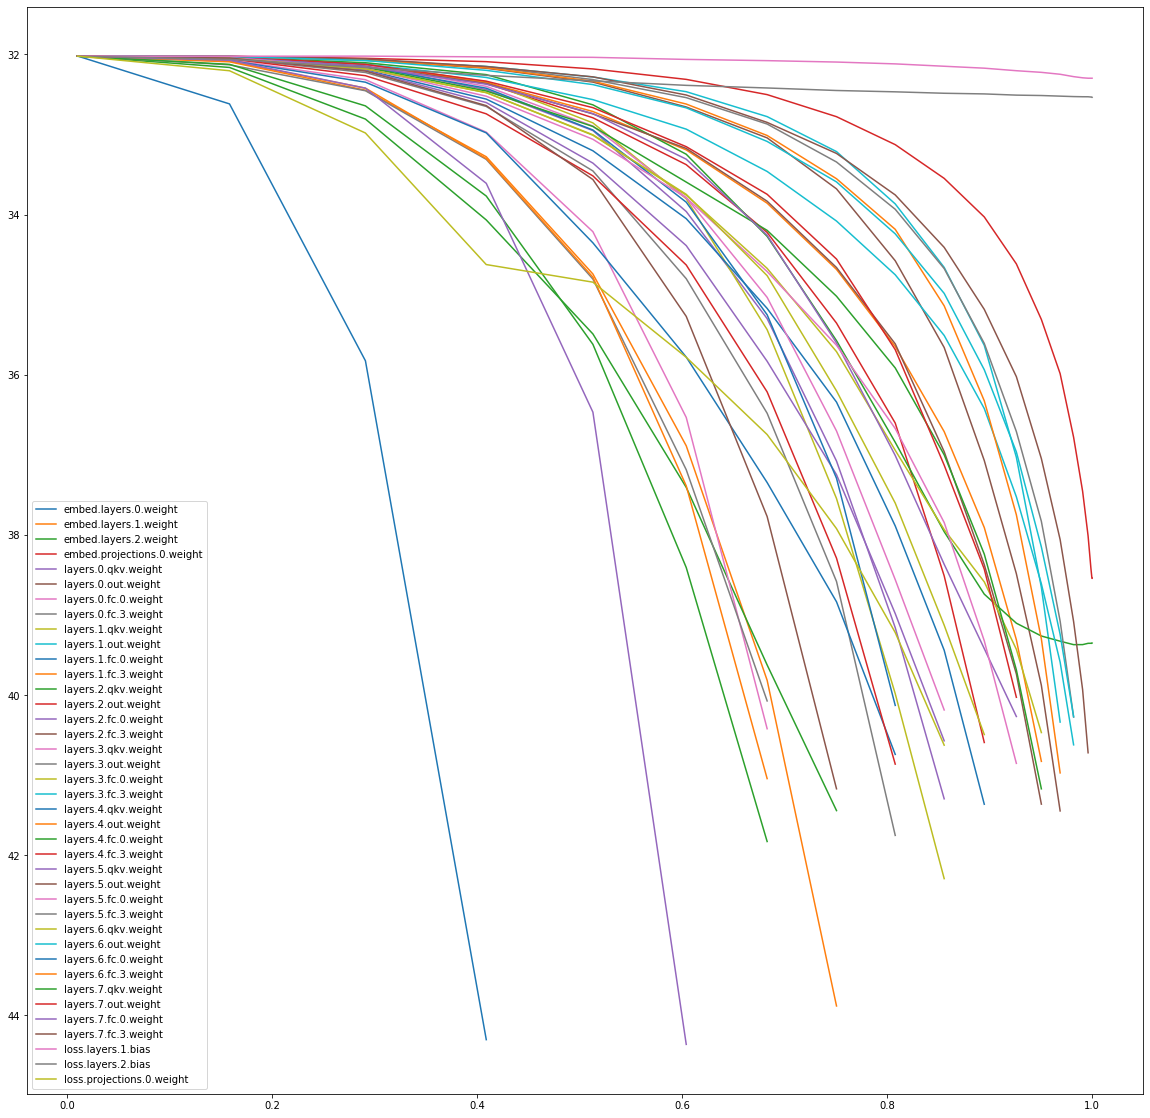

In [9]:
plt.figure(figsize=(20, 20))
plt.gca().invert_yaxis()
for layer_name, (numel, layer_info) in info.items():
    layer_info = np.array(layer_info)
    x = 1 - layer_info[:, 1]
    y = layer_info[:, 2]
    v.line(y, x, 'prune', name=layer_name)
    plt.plot(x, y, label=layer_name)
plt.legend()
plt.show()

In [10]:
info_save = {}
for layer_name, (numel, layer_info) in info.items():
    info_save[layer_name] = [numel, np.array(layer_info)]
(c_sen.res / 'sensitivities.npy').save(info_save)

# Validation of Correct Saving

In [3]:
distill_str = """
pruners:
  test_pruner:
      class: AutomatedGradualPruner
      initial_sparsity: 0.01
      final_sparsity: 1.00
      weights: [layers.6.out.weight]
policies:
  - pruner:
      instance_name: test_pruner
    starting_epoch: 0
    ending_epoch: 10
    frequency: 1
"""
d_c = yaml.load(distill_str)

import distiller
from main import get_net, get_opt, evaluate
c = Config(Wiki / 'shallow,layers_8', device='cuda:0', logger=False).load()
net = get_net(c)
opt = get_opt(c, net)
c.init_model(net, opt=opt, step='max', train=False)
compression_scheduler = distiller.config.dict_config(net, opt, d_c)

In [4]:
data_tr = SampleIterator(c, c.train_batch, split='valid' if c.debug else 'train')
iter_tr = iter(data_tr)
data_val = SequentialIterator(c, c.eval_batch, split='valid')

In [5]:
parameters = dict(net.named_parameters())
layer_name = 'layers.6.out.weight'

In [6]:
def evaluate_step():
    density = distiller.density(parameters[layer_name])
    ppl = np.e ** evaluate(c, data_val, net)['loss']
    return density, ppl

from copy import deepcopy
c_temp = deepcopy(c)
c_temp.res = Wiki / 'temp'

with torch.no_grad():
    print('Initial density %.5g ppl %.5g' % evaluate_step())
    for epoch in range(10):
        compression_scheduler.on_epoch_begin(epoch)
        compression_scheduler.on_minibatch_begin(epoch, minibatch_id=1, minibatches_per_epoch=1)
        x = to_torch(next(iter_tr), c.device).t()
        inputs, labels = x[:-1], x[1:]
        preds = net(inputs, labels)
        loss = preds['loss']
        loss = compression_scheduler.before_backward_pass(epoch, minibatch_id=1,
                                                               minibatches_per_epoch=1,
                                                               loss=loss, return_loss_components=False)
        compression_scheduler.on_minibatch_end(epoch, minibatch_id=1, minibatches_per_epoch=1)
        compression_scheduler.on_epoch_end(epoch)
        print('Epoch %s density %.5g ppl %.5g' % (epoch + 1, *evaluate_step()))
        c_temp.save_state(epoch, c_temp.get_state(net, opt, epoch), link_best=False)

Initial density 1 ppl 37.187
Epoch 1 density 0.99001 ppl 37.187
Saved model /data/scratch/zxyan/micronet/wikitext-103/temp/models/model-0.pth at step 0
Epoch 2 density 0.69531 ppl 37.274
Saved model /data/scratch/zxyan/micronet/wikitext-103/temp/models/model-1.pth at step 1
Epoch 3 density 0.46582 ppl 37.699
Saved model /data/scratch/zxyan/micronet/wikitext-103/temp/models/model-2.pth at step 2
Epoch 4 density 0.29333 ppl 38.714
Saved model /data/scratch/zxyan/micronet/wikitext-103/temp/models/model-3.pth at step 3
Epoch 5 density 0.16976 ppl 40.354
Saved model /data/scratch/zxyan/micronet/wikitext-103/temp/models/model-4.pth at step 4
Epoch 6 density 0.086914 ppl 42.824
Saved model /data/scratch/zxyan/micronet/wikitext-103/temp/models/model-5.pth at step 5
Epoch 7 density 0.036682 ppl 45.522
Saved model /data/scratch/zxyan/micronet/wikitext-103/temp/models/model-6.pth at step 6
Epoch 8 density 0.010864 ppl 48.129
Saved model /data/scratch/zxyan/micronet/wikitext-103/temp/models/model-

In [8]:
with torch.no_grad():
    print('Initial density %.5g ppl %.5g' % evaluate_step())
    for epoch in range(10):
        net, _ = c_temp.init_model(net, opt=None, step=epoch, train=False)
        print('Epoch %s density %.5g ppl %.5g' % (epoch + 1, *evaluate_step()))

Initial density 0.46582 ppl 37.699
Epoch 1 density 0.99001 ppl 37.187
Epoch 2 density 0.69531 ppl 37.274
Epoch 3 density 0.46582 ppl 37.699
Epoch 4 density 0.29333 ppl 38.714
Epoch 5 density 0.16976 ppl 40.354
Epoch 6 density 0.086914 ppl 42.824
Epoch 7 density 0.036682 ppl 45.522
Epoch 8 density 0.010864 ppl 48.129
Epoch 9 density 0.0013631 ppl 49.695
Epoch 10 density 0 ppl 49.508
